<a href="https://colab.research.google.com/github/Tanmoym047/garbage-detection/blob/main/garbage_efficientB1_epoch50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Working dir
import os, pathlib, sys, random, numpy as np, tensorflow as tf
WORK_DIR = '/content/garbage_project'
os.makedirs(WORK_DIR, exist_ok=True)
%cd $WORK_DIR


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/garbage_project


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

# (Optional) speed opts — safe on most Colab runtimes
try:
    tf.config.optimizer.set_jit(True)   # XLA
except Exception as e:
    print("XLA not enabled:", e)
try:
    from tensorflow.keras.mixed_precision import set_global_policy
    set_global_policy("mixed_float16")  # automatic loss scaling on GPU
    print("Mixed precision enabled.")
except Exception as e:
    print("Mixed precision not enabled:", e)

TensorFlow: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mixed precision enabled.


Total valid images: 19776  | Skipped bad/non-images: 0
Classes: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


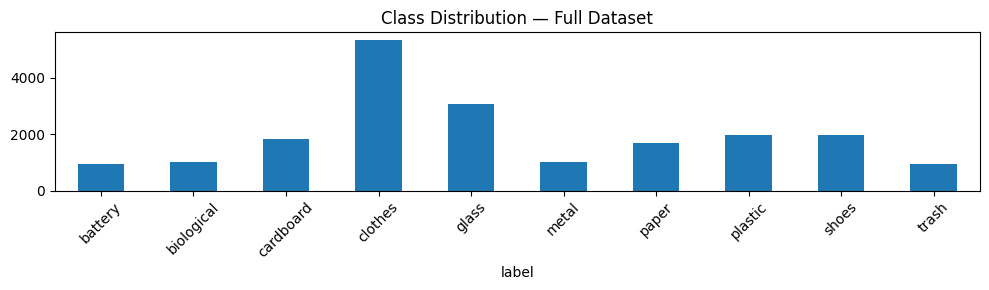

In [5]:
# =========================
# Colab cell 2: Point to dataset dir
# =========================
from pathlib import Path
from PIL import Image, UnidentifiedImageError
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# If using Kaggle: auto-discover class root
def find_class_root(base: Path, target_classes):
    targets = set(c.lower() for c in target_classes)
    for p in [base] + list(base.rglob("*")):
        if p.is_dir():
            subs = [d.name.lower() for d in p.iterdir() if d.is_dir()]
            if len(set(subs) & targets) >= 9:
                return p
    return base

TARGET_CLASSES = ["battery","biological","cardboard","clothes","glass","metal","paper","plastic","shoes","trash"]
ALLOWED_EXTS   = {".jpg",".jpeg",".png",".bmp",".webp",".jfif"}

    # 👇 change this to your Drive dataset folder if not using Kaggle
DATA_DIR = Path('/content/drive/MyDrive/garbage-dataset')


# Enumerate files, filter non-images & corrupts
all_rows, bad_files = [], []
for cls_dir in sorted([d for d in DATA_DIR.iterdir() if d.is_dir()]):
    cname = cls_dir.name.lower()
    if cname not in [c.lower() for c in TARGET_CLASSES]:
        continue
    for f in cls_dir.rglob("*"):
        if f.is_file() and f.suffix.lower() in ALLOWED_EXTS:
            try:
                with Image.open(f) as im: im.verify()
                all_rows.append({"filepath": str(f), "label": cls_dir.name})
            except (UnidentifiedImageError, OSError, ValueError):
                bad_files.append(str(f))
        elif f.is_file():
            bad_files.append(str(f))

df_all = pd.DataFrame(all_rows)
print("Total valid images:", len(df_all), " | Skipped bad/non-images:", len(bad_files))

# Class list & counts
classes = sorted(df_all['label'].unique().tolist())
print("Classes:", classes)
cnt = df_all['label'].value_counts().loc[classes]
cnt.plot(kind="bar", figsize=(10,3), title="Class Distribution — Full Dataset")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()


Train: (11865, 2)  Val: (3955, 2)  Test: (3956, 2)


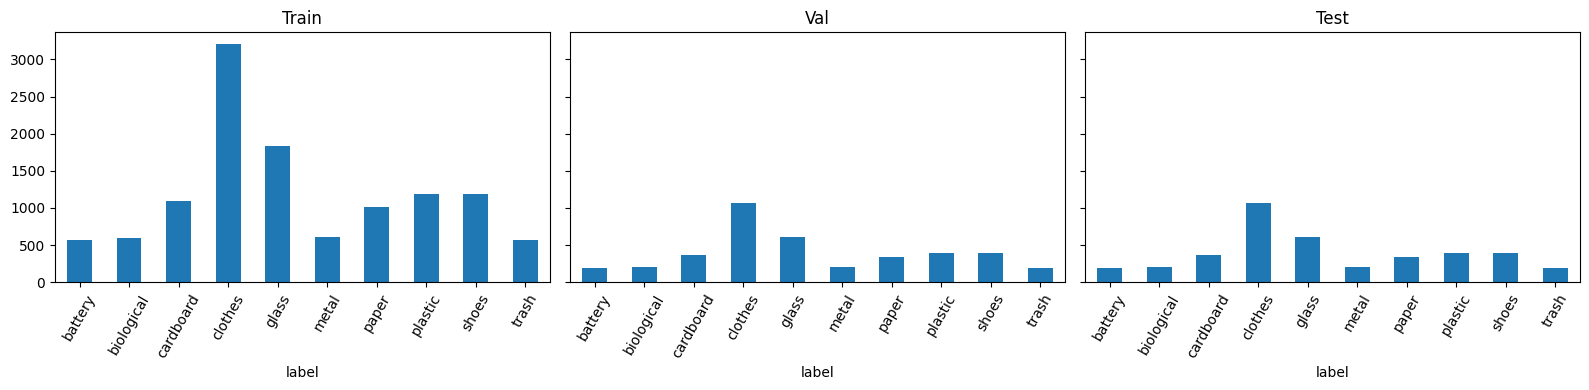

Saved splits to ./splits/ (include in paper supplementary).


In [6]:
# =========================
# Colab cell 3: Stratified 60/20/20 split
# =========================
from sklearn.model_selection import train_test_split
import os

SEED = 42

# First: 60% train, 40% temp (val+test)
train_df, temp_df = train_test_split(
    df_all,
    test_size=0.40,                 # <-- 40% goes to temp (val+test)
    stratify=df_all['label'],
    random_state=SEED
)

# Then: split temp into 20% val, 20% test (i.e., 50/50 of temp)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,                 # <-- half of temp -> 20% of total
    stratify=temp_df['label'],
    random_state=SEED
)

print("Train:", train_df.shape, " Val:", val_df.shape, " Test:", test_df.shape)

# Save CSVs (reproducibility)
os.makedirs("splits", exist_ok=True)
train_df.to_csv("splits/train.csv", index=False)
val_df.to_csv("splits/val.csv", index=False)
test_df.to_csv("splits/test.csv", index=False)

# Class distribution in each split
fig, axes = plt.subplots(1,3, figsize=(16,4), sharey=True)
for ax, df, title in zip(axes, [train_df, val_df, test_df], ["Train","Val","Test"]):
    counts = df['label'].value_counts().loc[classes]
    counts.plot(kind="bar", ax=ax, title=title)
    ax.tick_params(axis='x', rotation=60)
plt.tight_layout(); plt.show()

print("Saved splits to ./splits/ (include in paper supplementary).")


In [7]:
# =========================
# Colab cell 4: tf.data pipelines
# =========================
import tensorflow as tf
import numpy as np
AUTOTUNE = tf.data.AUTOTUNE

# EfficientNetB1 default resolution
IMG_SIZE = 240          # <-- was 224 for ResNet
BATCH_SIZE = 32         # If you hit OOM, try 24 or 16

# Label mapping
class_to_index = {c:i for i,c in enumerate(classes)}
index_to_class = {i:c for c,i in class_to_index.items()}

def df_to_dataset(df, shuffle=True, augment=False, cache=False):
    paths  = df['filepath'].values
    labels = df['label'].map(class_to_index).astype(np.int32).values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(min(len(paths), 4000), seed=SEED, reshuffle_each_iteration=True)

    def _load(path, label):
        img_b = tf.io.read_file(path)
        img   = tf.io.decode_image(img_b, channels=3, expand_animations=False)   # RGB
        img.set_shape([None, None, 3])
        img   = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method="bilinear")
        img   = tf.cast(img, tf.float32)  # keep 0..255; EfficientNet preprocess layer will handle scaling
        return img, label

    ds = ds.map(_load, num_parallel_calls=AUTOTUNE)

    # Augment (train only)
    aug = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.08),
        tf.keras.layers.RandomZoom(0.10),
        tf.keras.layers.RandomContrast(0.10),
    ], name="augment")

    def _aug(x,y):
        x = tf.image.random_brightness(x, max_delta=20.0)  # still safe on 0..255 range
        x = tf.clip_by_value(x, 0.0, 255.0)
        x = aug(x, training=True)
        return x, y

    if augment:
        ds = ds.map(_aug, num_parallel_calls=AUTOTUNE)

    ds = ds.batch(BATCH_SIZE, drop_remainder=False)
    if cache: ds = ds.cache()
    ds = ds.prefetch(AUTOTUNE)
    try:
        ds = ds.apply(tf.data.experimental.ignore_errors())
    except:
        pass
    return ds

train_ds = df_to_dataset(train_df, shuffle=True,  augment=True,  cache=False)
val_ds   = df_to_dataset(val_df,   shuffle=False, augment=False, cache=False)
test_ds  = df_to_dataset(test_df,  shuffle=False, augment=False, cache=False)

for imgs, labs in train_ds.take(1):
    print("Sanity batch:", imgs.shape, labs.shape, imgs.dtype)


Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


Sanity batch: (32, 240, 240, 3) (32,) <dtype: 'float16'>


In [8]:
# =========================
# Colab cell 5: Class weights
# =========================
from sklearn.utils.class_weight import compute_class_weight
y_train = train_df['label'].map(class_to_index).values
cw = compute_class_weight(class_weight='balanced',
                          classes=np.arange(len(classes)),
                          y=y_train)
CLASS_WEIGHTS = {i: float(w) for i,w in enumerate(cw)}
print("Class weights:", {index_to_class[i]: round(w,3) for i,w in CLASS_WEIGHTS.items()})


Class weights: {'battery': 2.096, 'biological': 1.984, 'cardboard': 1.084, 'clothes': 0.37, 'glass': 0.646, 'metal': 1.939, 'paper': 1.177, 'plastic': 0.997, 'shoes': 1.0, 'trash': 2.089}


In [9]:
# =========================
# Colab cell 6: Model build (EfficientNetB1)
# =========================
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications.efficientnet import preprocess_input as en_preprocess
import numpy as np

def build_efficientnetb1(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=len(classes), dropout=0.4):
    inputs = layers.Input(shape=input_shape, name="image")

    # EfficientNetB1 expects 0..255 floats; this layer applies the official preprocessing
    x = layers.Lambda(en_preprocess, name="preprocess")(inputs)

    # Base model
    base = EfficientNetB1(include_top=False, weights="imagenet", input_tensor=x)
    base.trainable = False  # freeze encoder for Stage A

    x = base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)  # keep float32 head for mixed precision

    model = models.Model(inputs, outputs, name="EfficientNetB1_Garbage")

    # convenient handles for fine-tuning later
    model._base = base
    model._unfreeze_k = 40   # unfreeze ~top 40 layers in Stage B (tune if you like)

    model.summary(line_length=110)
    trainable = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    nontrain  = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])
    print(f"Trainable params: {trainable:,} | Non-trainable: {nontrain:,}")
    return model

model = build_efficientnetb1()


27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EfficientNetB1_Garbage"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                   ┃ Output Shape              ┃          Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)             │ (None, 240, 240, 3)       │                0 │ -                          │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ preprocess (Lambda)            │ (None, 240, 240, 3)       │                0 │ image[0][0]                │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ rescaling (Rescaling)          │ (None, 240, 240, 3)       │                0 │ preprocess[0][0]           │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ normalization (Normalization)  │ (None, 240, 240, 3)       │                7 │ rescaling[0][0]            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)        │ (None, 240, 240, 3)       │                0 │ normalization[0][0]        │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D)  │ (None, 241, 241, 3)       │                0 │ rescaling_1[0][0]          │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)             │ (None, 120, 120, 32)      │              864 │ stem_conv_pad[0][0]        │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)   │ (None, 120, 120, 32)      │              128 │ stem_conv[0][0]            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ stem_activation (Activation)   │ (None, 120, 120, 32)      │                0 │ stem_bn[0][0]              │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ block1a_dwconv                 │ (None, 120, 120, 32)      │              288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)              │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ block1a_bn                     │ (None, 120, 120, 32)      │              128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)           │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ block1a_activation             │ (None, 120, 120, 32)      │                0 │ block1a_bn[0][0]           │
│ (Activation)                   │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ block1a_se_squeeze             │ (None, 32)                │                0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)       │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)   │ (None, 1, 1, 32)          │                0 │ block1a_se_squeeze[0][0]   │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)     │ (None, 1, 1, 8)           │              264 │ block1a_se_reshape[0][0]   │
├───

 Total params: 6,588,049 (25.13 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 6,575,239 (25.08 MB)

Trainable params: 12,810 | Non-trainable: 6,575,239.0


In [10]:
# =========================
# Colab cell 7: Stage A training (head only, 10 epochs)
# =========================
import time
class EpochTimer(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None): self.times = []
    def on_epoch_begin(self, epoch, logs=None): self._t = time.time()
    def on_epoch_end(self, epoch, logs=None): self.times.append(time.time() - self._t)

EPOCHS_STAGE1 = 10   # <-- Stage A: 10 epochs
timerA = EpochTimer()

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

cbA = [
    tf.keras.callbacks.ModelCheckpoint(
        "efficientnetb1_stage1.keras",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    timerA
]

histA = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE1,
    class_weight=CLASS_WEIGHTS,
    callbacks=cbA,
    verbose=1
)


Epoch 1/10
    369/Unknown 489s 1s/step - accuracy: 0.7055 - loss: 1.1080   

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.26930, saving model to efficientnetb1_stage1.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 594s 1s/step - accuracy: 0.7058 - loss: 1.1069 - val_accuracy: 0.9188 - val_loss: 0.2693 - learning_rate: 0.0010
Epoch 2/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.8995 - loss: 0.3633
Epoch 2: val_loss improved from 0.26930 to 0.21099, saving model to efficientnetb1_stage1.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 251s 681ms/step - accuracy: 0.8995 - loss: 0.3633 - val_accuracy: 0.9343 - val_loss: 0.2110 - learning_rate: 0.0010
Epoch 3/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.9128 - loss: 0.3022
Epoch 3: val_loss improved from 0.21099 to 0.19369, saving model to efficientnetb1_stage1.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 253s 684ms/step - accuracy: 0.9128 - loss: 0.3022 - val_accuracy: 0.9378 - val_loss: 0.1937 - learning_rate: 0.0010
Epoch 4/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.9160 - loss: 0.2891
Epoch 4: val_loss i

In [ ]:
# =========================
# Colab cell 8: Stage B fine-tuning (top layers, 40 epochs)
# =========================
# Unfreeze top-k layers of the base
k = getattr(model, "_unfreeze_k", 40)
model._base.trainable = True
for layer in model._base.layers[:-k]:
    layer.trainable = False
for layer in model._base.layers[-k:]:
    layer.trainable = True

EPOCHS_STAGE2 = 40   # <-- Stage B: 40 epochs (10 + 40 total)
timerB = EpochTimer()

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

cbB = [
    tf.keras.callbacks.ModelCheckpoint(
        "efficientnetb1_finetuned.keras",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    timerB
]

histB = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE2,
    class_weight=CLASS_WEIGHTS,
    callbacks=cbB,
    verbose=1
)

# Save final model
model.save("final_efficientnetb1.keras")
print("Saved final_efficientnetb1.keras")


Epoch 1/40



Test Accuracy: 0.9545  |  Macro-Precision: 0.9399  Macro-Recall: 0.9515  Macro-F1: 0.9450

              precision    recall  f1-score   support

     battery     0.9684    0.9787    0.9735        94
  biological     0.9804    1.0000    0.9901       100
   cardboard     0.9412    0.9617    0.9514       183
     clothes     0.9925    0.9850    0.9887       534
       glass     0.9722    0.9150    0.9428       306
       metal     0.8235    0.9608    0.8869       102
       paper     0.9563    0.9107    0.9329       168
     plastic     0.9289    0.9196    0.9242       199
       shoes     0.9608    0.9899    0.9751       198
       trash     0.8750    0.8936    0.8842        94

    accuracy                         0.9545      1978
   macro avg     0.9399    0.9515    0.9450      1978
weighted avg     0.9559    0.9545    0.9547      1978



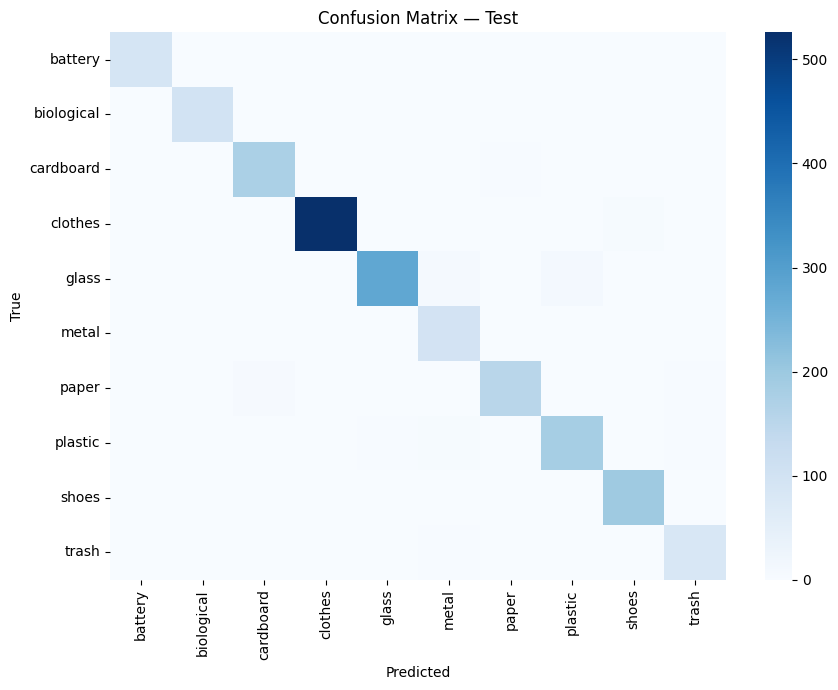

Avg time/epoch (approx): 369.76s
Model size: 72.70 MB


In [ ]:
# =========================
# Colab cell 9: Evaluation
# =========================
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Inference on test
y_true, y_pred = [], []
for x_batch, y_batch in test_ds:
    preds = model.predict(x_batch, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1).tolist())
    y_true.extend(y_batch.numpy().tolist())

y_true = np.array(y_true); y_pred = np.array(y_pred)
acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)

print(f"\nTest Accuracy: {acc:.4f}  |  Macro-Precision: {prec:.4f}  Macro-Recall: {rec:.4f}  Macro-F1: {f1:.4f}\n")
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(9,7))
sns.heatmap(cm, cmap="Blues", xticklabels=classes, yticklabels=classes, cbar=True)
plt.title("Confusion Matrix — Test"); plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()

# Per-class metrics CSV
p_i, r_i, f1_i, sup_i = precision_recall_fscore_support(y_true, y_pred, labels=range(len(classes)), zero_division=0)
df_metrics = pd.DataFrame({"class": classes, "precision": p_i, "recall": r_i, "f1": f1_i, "support": sup_i})
df_metrics.to_csv("per_class_metrics.csv", index=False); df_metrics.head()

# Time per epoch & model size
def path_size_mb(path):
    import os
    if os.path.isfile(path): return os.path.getsize(path)/(1024*1024)
    total=0
    for r,_,fs in os.walk(path):
        for f in fs: total += os.path.getsize(os.path.join(r,f))
    return total/(1024*1024)

avg_time_epoch = float(np.mean(timerA.times + timerB.times)) if (timerA.times or timerB.times) else np.nan
print(f"Avg time/epoch (approx): {avg_time_epoch:.2f}s")
print("Model size:", f"{path_size_mb('final_efficientnetb1.keras'):.2f} MB")  # <-- updated filename
